# Import libraries and setup matplotlib

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('waveglow/')

import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as ipd
import pickle as pkl
import librosa
from text import *
import numpy as np
import torch
import hparams
from modules.model import Model
from denoiser import Denoiser

### Text preprocessing

In [2]:
from g2p_en import G2p
from text.symbols import symbols
from text.cleaners import custom_english_cleaners

# Mappings from symbol to numeric ID and vice versa:
symbol_to_id = {s: i for i, s in enumerate(symbols)}
id_to_symbol = {i: s for i, s in enumerate(symbols)}

g2p = G2p()
def text2seq(text, data_type='char'):
    text = custom_english_cleaners(text.rstrip())
    if data_type=='phone':
        clean_phone = []
        for s in g2p(text.lower()):
            if '@'+s in symbol_to_id:
                clean_phone.append('@'+s)
            else:
                clean_phone.append(s)
                text = clean_phone
    
    # Append SOS, EOS token
    sequence = [symbol_to_id[c] for c in text]
    sequence = [symbol_to_id['^']] + sequence + [symbol_to_id['~']]
    return sequence

### Waveglow

In [3]:
waveglow_path = 'training_log/waveglow_256channels.pt'
waveglow = torch.load(waveglow_path)['model']

for m in waveglow.modules():
    if 'Conv' in str(type(m)):
        setattr(m, 'padding_mode', 'zeros')

waveglow.cuda().eval()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

with open('filelists/ljs_audio_text_val_filelist.txt', 'r') as f:
    lines = [line.split('|') for line in f.read().splitlines()]

Step: 100000
Text: (LJ001-0029)
But though on the whole, except in Italy, Gothic letter was most often used

Melspectrogram: (LJ001-0029)


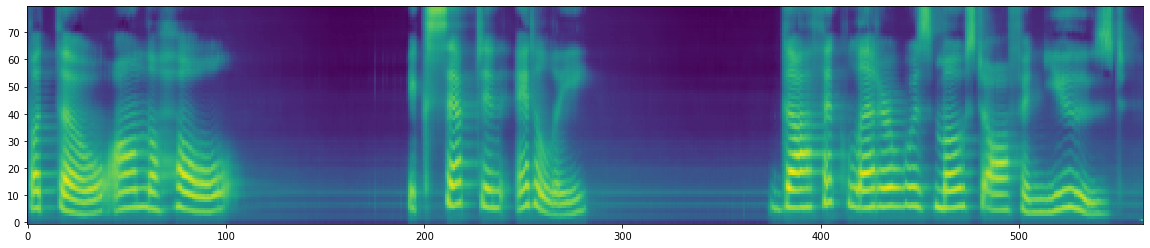

Audio: (LJ001-0029)


Stop: (LJ001-0029)


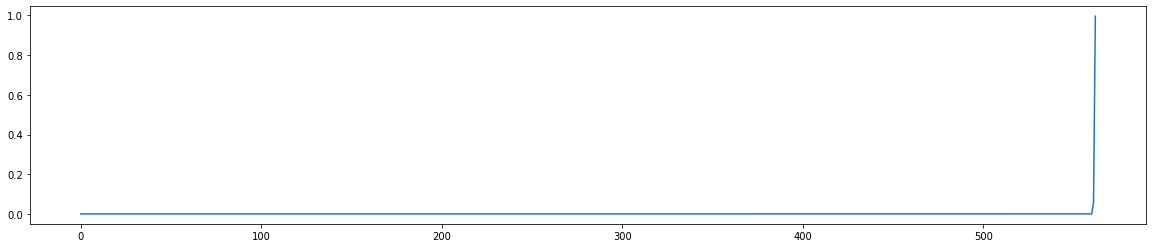

Enc_alignments: (LJ001-0029)


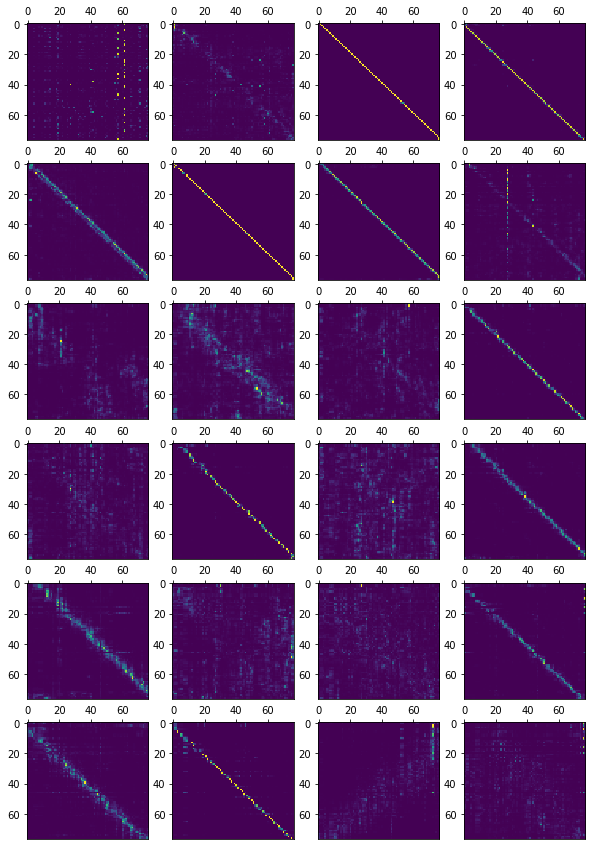

Dec_alignments: (LJ001-0029)


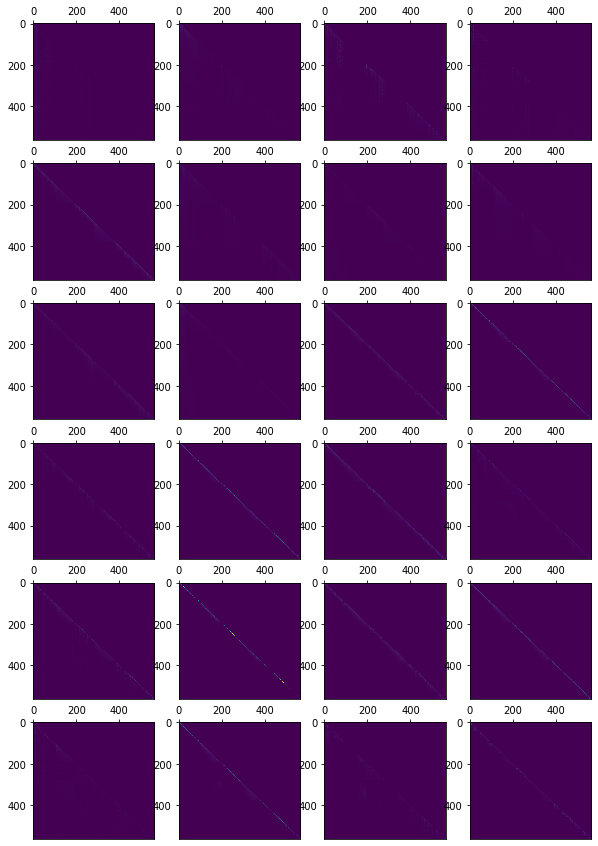

Enc_Dec_alignments: (LJ001-0029)


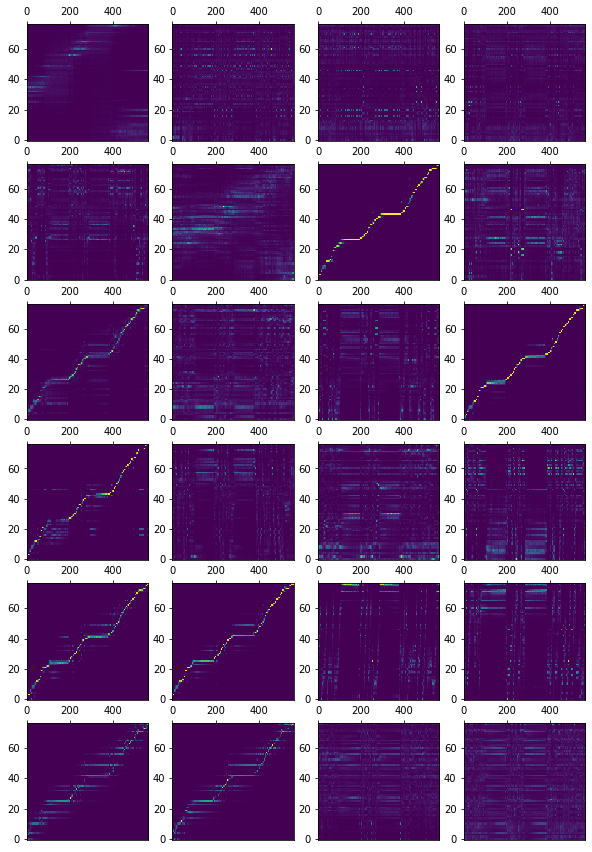

In [4]:
for steps in [100000]:
    print(f'Step: {steps}')
    checkpoint_path = f"training_log/transformer-tts-char/checkpoint_{steps}"
    state_dict = {}
    for k, v in torch.load(checkpoint_path)['state_dict'].items():
        state_dict[k[7:]]=v

    model = Model(hparams).cuda()
    model.load_state_dict(state_dict)
    _ = model.cuda().eval()

    for i in [1]:
        file_name, _, text = lines[i]
        sequence = np.array(text2seq(text, data_type='char'))[None, :]
        sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()

        with torch.no_grad():
            melspec, enc_alignments, dec_alignments, enc_dec_alignments, stop = model.inference(sequence, max_len=1024)
            n_layers, n_heads = enc_dec_alignments.size()[:2]
            T=len(stop)
            melspec = melspec[:,:,:T]
            audio = waveglow.infer(melspec, sigma=0.666)


        print(f"Text: ({file_name})")
        print(text)
        print()


        print(f"Melspectrogram: ({file_name})")
        plt.figure(figsize=(20,4))
        plt.imshow(melspec[0,:,:T].detach().cpu(), origin='lower', aspect='auto')
        plt.show()


        print(f"Audio: ({file_name})")
        audio_denoised = denoiser(audio, strength=0.01)[:, 0]
        ipd.display(ipd.Audio(audio_denoised.cpu().numpy(),
                              rate=hparams.sampling_rate))

        print(f"Stop: ({file_name})")
        plt.figure(figsize=(20,4))
        plt.plot(stop)
        plt.show()


        print(f"Enc_alignments: ({file_name})")
        fig, axes = plt.subplots(n_layers,n_heads,figsize=(10,15))
        for layer in range(n_layers):
            for head in range(n_heads):
                align = enc_alignments[layer][head].contiguous().detach().cpu()
                axes[layer,head].imshow(align, aspect='auto')
                axes[layer,head].xaxis.tick_top()
        plt.show()


        print(f"Dec_alignments: ({file_name})")
        fig, axes = plt.subplots(n_layers,n_heads,figsize=(10,15))
        for layer in range(n_layers):
            for head in range(n_heads):
                align = dec_alignments[layer][head][:T,:T].contiguous().detach().cpu()
                axes[layer,head].imshow(align, aspect='auto')
                axes[layer,head].xaxis.tick_top()
        plt.show()


        print(f"Enc_Dec_alignments: ({file_name})")
        fig, axes = plt.subplots(n_layers,n_heads,figsize=(10,15))
        for layer in range(n_layers):
            for head in range(n_heads):
                align = enc_dec_alignments[layer][head][:T].t().contiguous().detach().cpu()
                axes[layer,head].imshow(align, origin='lower', aspect='auto')
                axes[layer,head].xaxis.tick_top()
        plt.show()